Name: Christian Hellum Bye

# Predicting a Pulsar Star

Based on previous work, we have trained a Random Forest Classifier (RFC) as our model. In this deliverable, we explore the relative importance of the features and see if we can further improve our model.

## Preprocessing the data

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split #to split the dataset

In [2]:
data = np.loadtxt('../pulsar_stars.csv', delimiter=',', skiprows=1)

In [3]:
X = data[:, 0:8] #features
y = data[:, 8] #classes

In [4]:
#split the dataset into two parts, 80 % containing training and validation sets, 20 % to the test set
X_train_validation, X_test, y_train_validation, y_test = train_test_split(X, y, test_size=0.2)

#split the larger part of the dataset to two parts: 75 % (= 60 % of the total data) to training set, 25 % (= 20 % of the total)
#to the validation set
X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, y_train_validation, test_size=0.25)

## Feature importance

In [35]:
#import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from matplotlib import pyplot as plt
import pickle

In [6]:
rfc = pickle.load(open('RFC_weigths.sav', 'rb')) #load weights

C:\Users\Admin\Documents\PYTHON\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\Documents\PYTHON\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\Documents\PYTHON\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.22.

In [7]:
#feature labels
feat_labels = ['Mean of the integrated profile', 'Standard deviation of the integrated profile', 'Excess kurtosis of the integrated profile', 'Skewness of the integrated profile', 'Mean of the DM-SNR curve', 'Standard deviation of the DM-SNR curve', 'Excess kurtosis of the DM-SNR curve', 'Skewness of the DM-SNR curve']

In [8]:
for feature in zip(feat_labels, rfc.feature_importances_):
    print(feature)

('Mean of the integrated profile', 0.246078065428781)
('Standard deviation of the integrated profile', 0.026256904658293712)
('Excess kurtosis of the integrated profile', 0.389001337277414)
('Skewness of the integrated profile', 0.15003699764332742)
('Mean of the DM-SNR curve', 0.0442104741037564)
('Standard deviation of the DM-SNR curve', 0.10189573846224295)
('Excess kurtosis of the DM-SNR curve', 0.01988925040409805)
('Skewness of the DM-SNR curve', 0.02263123202208658)


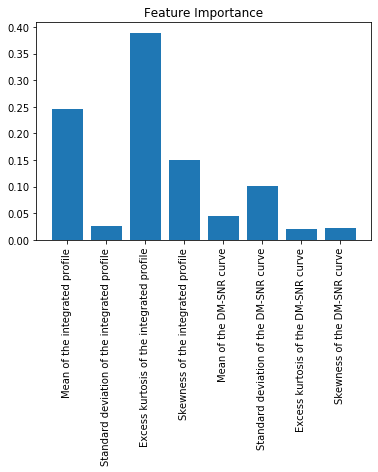

In [54]:
plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), rfc.feature_importances_)
plt.xticks(range(X_train.shape[1]), feat_labels, rotation=90)
plt.show()

We see that four of the features have importance scores of less than 10 %, whereas the other four account for over 85 % of the importance in total. We will train a model based on the four important features:

In [9]:
important_cols = [0, 2, 3, 5] #the coloumns in the dataset corresponding to the important features

In [10]:
X_train_important = X_train[:, important_cols]
X_validation_important = X_validation[:, important_cols]
X_test_important = X_test[:, important_cols]

We now proceed the same way as in the previous deliverable to set the hyperparameters (all code in this part is copied from deliverable 3):

In [11]:
def rfc_f1(n_estimators, min_samples_split, max_features):
    rfc_important = RandomForestClassifier(n_estimators = n_estimators, min_samples_split = min_samples_split, max_features = max_features, class_weight='balanced')
    rfc_important.fit(X_train_important, y_train) #fits to training set
    
    #make predictions
    train_predict = rfc_important.predict(X_train_important)
    validation_predict = rfc_important.predict(X_validation_important)
    
    rfc_tr_f1 = f1_score(y_train, train_predict) #f1-score for training data
    rfc_validation_f1 = f1_score(y_validation, validation_predict) #f1-score for test data
    
    return rfc_tr_f1, rfc_validation_f1

In [12]:
n_vals = np.arange(1,51) #n_estimators
min_sample_split_vals = np.arange(2,11) #min_sample_split
max_features_vals = np.arange(1,5) #max_features

In [59]:
f1_scores_rfc_train = np.empty((50, 9, 4))
f1_scores_rfc_validation = np.empty((50, 9, 4))
for i in range(50): #loop through values of n_estimators
    for j in range(9): #loop through values of min_sample_split
        for k in range(4): #loop through values of max_features
            f1_scores_rfc_train[i,j,k], f1_scores_rfc_validation[i,j,k] = rfc_f1(n_vals[i], min_sample_split_vals[j], max_features_vals[k])

In [60]:
#flatten the arrays
f1_tr = np.ravel(f1_scores_rfc_train)
f1_val = np.ravel(f1_scores_rfc_validation)

In [62]:
max_index_rfc = np.argmax(f1_val) #the index corresponding to the greatest f1-score for the validation data
print('Max f1-score for validation data set is:', f1_val[max_index_rfc]) #the f1-score at this index
print('The index that maximizes the f1-score is:', np.unravel_index(max_index_rfc, f1_scores_rfc_validation.shape))

Max f1-score for validation data set is: 0.900489396411093
The index that maximizes the f1-score is: (11, 3, 0)


The best parameters are:
* n_estimators = 10 (the 0th index has n_estimators = 1)
* min_sample_split = 5 (the 0th index has min_sample_split = 2, so the third has min_sample_split = 5)
* max_features = 1 (the 0th index has max_features = 1)

We test this:

In [17]:
rfc_important = RandomForestClassifier(n_estimators = 10, min_samples_split = 5, max_features = 1, class_weight='balanced')
rfc_important.fit(X_train_important, y_train) #fits to training set
    
test_predict_important = rfc_important.predict(X_test_important) #make predictions
rfc_important_test_f1 = f1_score(y_test, test_predict_important) #f1-score for test data

print('The f1-score for the test set is:', rfc_important_test_f1)

The f1-score for the test set is: 0.8539682539682539


The confusion matrix for this model is:

In [18]:
confusion_test_important = confusion_matrix(y_test, test_predict_important)
print('Confusion matrix for model based on the four most important features: \n')
print(confusion_test_important)

tn_important, fp_important, fn_important, tp_important = confusion_test_important.ravel()

print('\nTrue positives', tp_important)
print('True negatives', tn_important)
print('False positives', fp_important)
print('False negatives', fn_important)

Confusion matrix for model based on the four most important features: 

[[3219   30]
 [  62  269]]

True positives 269
True negatives 3219
False positives 30
False negatives 62


## Comparison

With all eigth features included, our model gives the following f1-score and confusion matrix:

In [19]:
test_predict = rfc.predict(X_test) #make predictions
rfc_test_f1 = f1_score(y_test, test_predict) #f1-score for test data

In [21]:
print('The f1-score for the test set is:', rfc_test_f1)

The f1-score for the test set is: 0.948012232415902


In [20]:
confusion_test = confusion_matrix(y_test, test_predict)
print('Confusion matrix: \n')
print(confusion_test)

tn, fp, fn, tp = confusion_test.ravel()

print('\nTrue positives', tp)
print('True negatives', tn)
print('False positives', fp)
print('False negatives', fn)

Confusion matrix: 

[[3236   13]
 [  21  310]]

True positives 310
True negatives 3236
False positives 13
False negatives 21


In [41]:
plot_confusion_matrix?

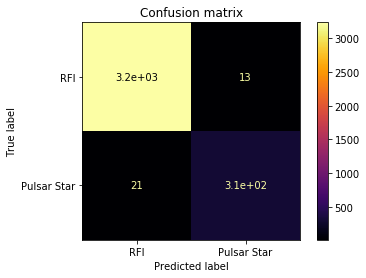

In [50]:
plot_confusion_matrix(rfc, X_test, y_test, display_labels=['RFI', 'Pulsar Star'], cmap='inferno')
plt.title('Confusion matrix')
plt.show()

It is clear that even though four of the features are significantly more important than the other four - both based on importance score and the fact that the model achieves a f1-score of 0.85 - the model that takes all features into account performs better by a margin. We conclude that none of the features are negligible and with only eigth features, there is no reason to disregard any of the features.